<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Bot de consulta abierta y respuestas predeterminadas con DNN + Spacy

#### Datos
Este ejemplo se inspiró en otro Bot en inglés creado con NLTK, lo tienen como referencia para hacer lo mismo en inglés:\
[LINK](https://towardsdatascience.com/a-simple-chatbot-in-python-with-deep-learning-3e8669997758)

### 1 - Instalar dependencias
Para poder utilizar Spacy en castellano es necesario agregar la librería "spacy-stanza" para lematizar palabras en español.

In [ ]:
# La última versión de spacy-stanza (>1.0) es compatible solo con spacy >=3.0
# Nota: spacy 3.0 incorpora al pipeline NLP transformers
# ADVERTENCIA: la instalación de SpaCy puede demorar más de 10 minutos!
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 7.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fiona 1.9.4.post1 requires click~=8.0, but you have click 7.1.2 which is incompatible.
flask 2.2.5 requires click>=8.0, but you have click 7.1.2 which is incompatible.
dask 2023.8.1 requires click>=8.0, but you have click 7.1.2 which is incompatible.
distributed 2023.8.1 requires click>=8.0, but you have click 7.1.2 which is incompatible.
en-core-web-sm 3.6.0 requires spacy<3.7.0,>=3.6.0, but you have spacy 3.1.0 which is incompatible.
inflect 7.0.0 requires pydantic>=1.9.1, but you h

In [ ]:
import json
import string
import random
import numpy as np

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
import stanza
import spacy_stanza

# Vamos a usar SpaCy-Stanza. Stanza es una librería de NLP de Stanford
# SpaCy armó un wrapper para los pipelines y modelos de Stanza
# https://stanfordnlp.github.io/stanza/

# Descargar el diccionario en español y armar el pipeline de NLP con spacy
stanza.download("es")
nlp = spacy_stanza.load_pipeline("es")

INFO:stanza:Downloading default packages for language: es (Spanish)...
INFO:stanza:File exists: /root/stanza_resources/es/default.zip.
INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

INFO:stanza:Use device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: depparse
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


### 2 - Herramientas de preprocesamiento de datos
Entre las tareas de procesamiento de texto en español se implementa:
- Quitar acentos y caracteres especiales
- Quitar números
- Quitar símbolos de puntuación

In [ ]:
import re
import unicodedata

# El preprocesamento en castellano requiere más trabajo

# Referencia de regex:
# https://docs.python.org/3/library/re.html

def preprocess_clean_text(text):
    # sacar tildes de las palabras:
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # quitar caracteres especiales
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' # [^ : ningún caracter de todos estos
    # (termina eliminando cualquier caracter distinto de los del regex)
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' # igual al anterior pero sin cifras numéricas
    # quitar números
    text = re.sub(pattern, '', text)
    # quitar caracteres de puntuación
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

In [ ]:
text = "personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
preprocess_clean_text(text.lower())

'personas ideas estas cosas y los peces y los murcielagos'

In [ ]:
# Ejemplo de como funciona
text = "hola personas Ideas! estás cosas y los peces y los murciélagos"

# Antes de preprocesar los datos se pasa a minúsculas todo el texto
tokens = nlp(preprocess_clean_text(text.lower()))
print("tokens:", tokens)
print("Lematización de cada token:")
for token in tokens:
    print([token, token.lemma_])

tokens: hola personas ideas estas cosas y los peces y los murcielagos
Lematización de cada token:
[hola, 'holar']
[personas, 'persona']
[ideas, 'idea']
[estas, 'este']
[cosas, 'cosa']
[y, 'y']
[los, 'el']
[peces, 'pez']
[y, 'y']
[los, 'el']
[murcielagos, 'murcielago']


### 3 - Diccionario de entrada

In [49]:
# Dataset en formato JSON que representa las posibles preguntas (patterns)
# y las posibles respuestas por categoría (tag)
# Los "patterns" van a formar el corpus para entrenar el clasificador que clasifica en tags
# "respones" son las respuestas predeterminadas posibles para cada tag
dataset = {"intents": [
             {"tag": "bienvenida",
              "patterns": ["Hola, hablo con las canchas de tenis?", "Buenas tardes", "¿Qué tal?"],
              "responses": ["Hola, ¿Cómo estás?. Somos el complejo de tenis del barrio X."],
             },
             {"tag": "canchas",
              "patterns": ["Quería averiguar por las canchas de tenis.", "Alquilan las canchas?","Te consulto para ir a jugar al tenis"],
              "responses": ["Tenemos 3 canchas, se alquilan en turnos de una hora."]
             },
            {"tag": "disponibilidad",
              "patterns": ["Para cuando tienen libre?", "Cual es el próximo turno?", "Tenes algun turno?", "Me guardas un turno?","Quiero reservar un turno","Me tomas una reserva?"],
              "responses": ["Tenemos turnos disponibles, para coordinar el horario escribir al número 1234-567890 por WhatsApp."]
             },
            {"tag": "cancelacion",
              "patterns": ["Te escribo para cancelar el turno", "Se nos complicó y no vamos a poder ir, podemos cambiar el turno para otro día?"],
              "responses": ["En caso de cancelación, con 24hs antes no tiene ningún costo, caso contrario se cobra el total del turno."]
             },
            {"tag": "precios",
              "patterns": ["Me podrás pasar los precios", "¿Cuánto vale el turno?", "¿Cuánto sale el turno?", "Cual es el costo del turno?", "Cuanto cuesta el turno?"],
              "responses": ["Antes de las 18hs el precio es $X y después $Y."]
             },
            {"tag": "pagos",
              "patterns": ["Se paga en el momento?","Que formas de pago tienen?","Se puede pagar con transferencia?"],
              "responses": ["Se debe pagar la seña del 50% por transferencia, y el resto se puede pagar en efectivo, con transferencia o Mercado Pago. "]
             },
            {"tag": "pelotas",
              "patterns": ["Pelotas y raquetas te prestan?", "Hay que llevar pelotas?", "No tenemos pelotas ni raquetas, se pueden alquilar?"],
              "responses": ["El costo del turno no incluye pelotas ni raquetas, se pueden alquilar por un extra de $X las pelotas y %Y las raquetas."]
             },
                {"tag": "ubicacion",
              "patterns": ["Donde queda el lugar?", "Las canchas donde estan?", "Donde son?"],
              "responses": ["La dirección es ............."]
             },
            {"tag": "agradecimientos",
              "patterns": [ "Muchas gracias", "Gracias","Nos vemos"],
              "responses": ["De nada, los esperamos!"]
             },
]}

### 4 - Preprocesamiento y armado del dataset

In [50]:
# Datos que necesitaremos, las palabras o vocabulario
words = []
classes = []
doc_X = []
doc_y = []

# Por cada intención (intents) debemos tomar los patrones que la caracterizan
# a esa intención y transformarla a tokens para almacenar en doc_X

# El tag de cada intención se almacena como doc_Y (la clase a predecir)
# En `words` vamos a guardar el vocabulario
# En `class` las posibles clases o tags

for intent in dataset["intents"]:
    for pattern in intent["patterns"]:
        # trasformar el patron a tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lematizar los tokens
        for token in tokens:
            words.append(token.lemma_)

        doc_X.append(pattern)
        doc_y.append(intent["tag"])

    # Agregar el tag a las clases
    if intent["tag"] not in classes:
        classes.append(intent["tag"])

# Elminar duplicados con "set" y ordenar el vocabulario y las clases por orden alfabético
words = sorted(set(words))
classes = sorted(set(classes))

<ipython-input-50-f8e9132a6cc2>:17: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(pattern.lower()))
<ipython-input-50-f8e9132a6cc2>:17: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['te', 'consulto', 'para', 'ir', 'a', 'jugar', 'a', 'el', 'tenis']
Entities: []
  tokens = nlp(preprocess_clean_text(pattern.lower()))
<ipython-input-50-f8e9132a6cc2>:17: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['se', 'e', 'nos', 'complico', 'y', 'no', 'vamos', 'a', 'poder', 'ir', 'podemos', 'cambiar', 'el', 'turno', 'para', 'otro', 'dia']
Entities: []
  tokens = nlp(preprocess_clean_text(pattern.lower()))
<ipython-i

In [51]:
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['a', 'alguno', 'alquilar', 'alquilir', 'averiguar', 'buen', 'cambiar', 'cancelar', 'cancha', 'complicar', 'con', 'consultar', 'costar', 'costo', 'cual', 'cuando', 'cuanto', 'de', 'dia', 'donde', 'e', 'el', 'en', 'escribir', 'estar', 'forma', 'gracias', 'guarda', 'haber', 'hablar', 'holar', 'ir', 'jugar', 'libre', 'llevar', 'lugar', 'momento', 'mucho', 'ni', 'no', 'otro', 'pagar', 'pago', 'para', 'pasar', 'pelota', 'poder', 'por', 'precio', 'prestar', 'proximo', 'que', 'quedar', 'querer', 'raqueta', 'reserva', 'reservar', 'salir', 'ser', 'tal', 'tarde', 'tener', 'tenis', 'tomar', 'transferencia', 'turno', 'tú', 'uno', 'valer', 'ver', 'y', 'yo', 'él']
classes: ['agradecimientos', 'bienvenida', 'cancelacion', 'canchas', 'disponibilidad', 'pagos', 'pelotas', 'precios', 'ubicacion']
doc_X: ['Hola, hablo con las canchas de tenis?', 'Buenas tardes', '¿Qué tal?', 'Quería averiguar por las canchas de tenis.', 'Alquilan las canchas?', 'Te consulto para ir a jugar al tenis', 'Para cuando 

In [52]:
# Tamaño del vocabulario
print("Vocabulario:", len(words))

Vocabulario: 73


In [53]:
# Cantidad de tags
print("Tags:", len(classes))

Tags: 9


In [54]:
# Transformar doc_X en bag of words por oneHotEncoding
# Transformar doc_Y en un vector de clases multicategórico con oneHotEncoding

training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transformar la pregunta (input) en tokens y lematizar
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transformar los tokens en "Bag of words" (arrays de 1 y 0)
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)

    # Crear el array de salida (class output) correspondiente
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    print("X:", bow, "y:", output_row)
    training.append([bow, output_row])

# Mezclar los datos
random.shuffle(training)
training = np.array(training, dtype=object)
# Dividir en datos de entrada y salida
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

X: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 1, 0, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 1,

<ipython-input-54-8e031f007c36>:10: UserWarning: Due to multiword token expansion or an alignment issue, the original text has been replaced by space-separated expanded tokens.
  tokens = nlp(preprocess_clean_text(doc.lower()))
<ipython-input-54-8e031f007c36>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['te', 'consulto', 'para', 'ir', 'a', 'jugar', 'a', 'el', 'tenis']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 1, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 1, 0, 0, 0, 0]
X: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0,

<ipython-input-54-8e031f007c36>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['se', 'e', 'nos', 'complico', 'y', 'no', 'vamos', 'a', 'poder', 'ir', 'podemos', 'cambiar', 'el', 'turno', 'para', 'otro', 'dia']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1] y: [0, 0, 1, 0, 0, 0, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] y: [0, 0, 0, 0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0,

<ipython-input-54-8e031f007c36>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['cual', 'es', 'el', 'costo', 'de', 'el', 'turno']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 0, 0, 1, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 0, 0, 1, 0, 0, 0]


<ipython-input-54-8e031f007c36>:10: UserWarning: Can't set named entities because of multi-word token expansion or because the character offsets don't map to valid tokens produced by the Stanza tokenizer:
Words: ['se', 'e', 'paga', 'en', 'el', 'momento']
Entities: []
  tokens = nlp(preprocess_clean_text(doc.lower()))


X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1] y: [0, 0, 0, 0, 0, 1, 0, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0] y: [0, 0, 0, 0, 0, 0, 1, 0, 0]
X: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] y: [0, 0, 0, 0,

### 5 - Entrenamiento del modelo

In [55]:
# Shape de entrada y salida
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (73,) output: 9


In [56]:
# Entrenamiento del modelo DNN
# - Modelo secuencial
# - Con regularización
# - softmax y optimizador Adam
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               9472      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 9)                 585       
                                                                 
Total params: 18313 (71.54 KB)
Trainable params: 18313 (71.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [57]:
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
1/1 [==============================] - 1s 762ms/step - loss: 2.2122 - accuracy: 0.0968
Epoch 2/200
1/1 [==============================] - 0s 12ms/step - loss: 2.2299 - accuracy: 0.1290
Epoch 3/200
1/1 [==============================] - 0s 11ms/step - loss: 2.1921 - accuracy: 0.0968
Epoch 4/200
1/1 [==============================] - 0s 15ms/step - loss: 2.2165 - accuracy: 0.0968
Epoch 5/200
1/1 [==============================] - 0s 12ms/step - loss: 2.1407 - accuracy: 0.2258
Epoch 6/200
1/1 [==============================] - 0s 15ms/step - loss: 2.0325 - accuracy: 0.3226
Epoch 7/200
1/1 [==============================] - 0s 14ms/step - loss: 2.1676 - accuracy: 0.2581
Epoch 8/200
1/1 [==============================] - 0s 11ms/step - loss: 2.1606 - accuracy: 0.1290
Epoch 9/200
1/1 [==============================] - 0s 12ms/step - loss: 2.2015 - accuracy: 0.1935
Epoch 10/200
1/1 [==============================] - 0s 11ms/step - loss: 1.9951 - accuracy: 0.2903
Epoch 11/200
1/1 [

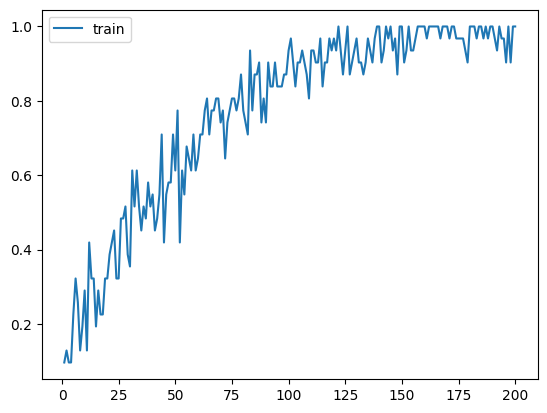

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
plt.show()

In [59]:
# Guardar lo necesario para poder re-utilizar este modelo en el futuro
# En NLP además de los modelos es necesario proveer: tokenizador y vocabulario.
# La tríada modelo+tokenizador+vocabulario es necesaria para hacer inferencia.
# Sin una de las tres no se puede hacer inferencia.

# en este caso guardamos:
# el vocabulario utilizado (words)
# las posibles clases
# el modelo
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 6 - Testing y validación

In [60]:
# convertir texto de entrada del usuario a tokens
def text_to_tokens(text):
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    #print(lemma_tokens)
    return lemma_tokens

# transformar el texto de entrada tokenizado a una representación OHE
def bag_of_words(text, vocab):
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens:
        for idx, word in enumerate(vocab):
            if word == w:
                bow[idx] = 1
    #print(bow)
    return np.array(bow)

# usar modelo con la entrada en OHE y los labels posibles (tags)
def pred_class(text, vocab, labels):
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0: # sólo si reconoció alguna palabra del vocabulario
        result = model.predict(np.array([bow]))[0] # es un array de softmax
        thresh = 0.2
        # filtrar aquellas entradas menores al umbral `thresh`
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        # ordenar keys de acuerdo al valor softmax
        y_pred.sort(key=lambda x: x[1], reverse=True)

        # return_list es una lista de los labels de mayor a menor
        for r in y_pred:
            return_list.append(labels[r[0]])
            #print(labels[r[0]], r[1])

    # si no reconoció palabras del vocabulario se devuelve una lista vacía
    return return_list

# obtener una respuesta predeterminada
def get_response(intents_list, intents_json):
    tag = intents_list[0] # tomar el tag con el mejor valor softmax
    list_of_intents = intents_json["intents"] # intents_json es todo el dataset
    for i in list_of_intents:
        if i["tag"] == tag: # buscar el tag correspoindiente y dar una respuesta predeterminada aleatoria
            result = random.choice(i["responses"])
            break
    return result

In [68]:
# Define las preguntas en una lista
preguntas = [
    "Hola, como estas? Hablo con las canchas de tenis?",
    "Quisiera reservar un turno, puede ser?",
    "Cuanto sale el turno?",
    "Hay que llevar pelotas?",
    "Donde queda el lugar?",
    "Hay que pagar en el momento o con anticipación?",
    "Gracias, nos vemos!"
    # Agrega más preguntas según sea necesario
]

# Itera a través de las preguntas y obtén las respuestas del bot
for pregunta in preguntas:
    print("Pregunta:", pregunta)

    # Obten respuesta del bot usando tu código existente
    intents = pred_class(pregunta, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset)
        print("BOT:", result)
    else:
        print("BOT: Perdón, no comprendo la pregunta.")

Pregunta: Hola, como estas? Hablo con las canchas de tenis?
1/1 [==============================] - 0s 43ms/step
BOT: Hola, ¿Cómo estás?. Somos el complejo de tenis del barrio X.
Pregunta: Quisiera reservar un turno, puede ser?
1/1 [==============================] - 0s 50ms/step
BOT: Tenemos turnos disponibles, para coordinar el horario escribir al número 1234-567890 por WhatsApp.
Pregunta: Cuanto sale el turno?
1/1 [==============================] - 0s 49ms/step
BOT: Antes de las 18hs el precio es $X y después $Y.
Pregunta: Hay que llevar pelotas?
1/1 [==============================] - 0s 26ms/step
BOT: El costo del turno no incluye pelotas ni raquetas, se pueden alquilar por un extra de $X las pelotas y %Y las raquetas.
Pregunta: Donde queda el lugar?
1/1 [==============================] - 0s 23ms/step
BOT: La dirección es .............
Pregunta: Hay que pagar en el momento o con anticipación?
1/1 [==============================] - 0s 21ms/step
BOT: Se debe pagar la seña del 50% por t

### 7 - Conclusiones
El bot tal cual está definido es capaz de responder a bastantes tipos de preguntas con gran precisión. Algunas técnicas que podrían ensayarse para evaluar como impactan en el sistema son:
- Filtrar los stop words
- Utilizar TF-IDF en vez de bag of words

### Alumno

- Tomar un ejemplo de los bots utilizados (uno de los dos) y construir el propio.
- Sacar conclusiones de los resultados.

__IMPORTANTE__: Recuerde para la entrega del ejercicio debe quedar registrado en el colab las preguntas y las respuestas del BOT para que podamos evaluar el desempeño final.